In [1]:
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

### RHMC on 2D High Energy Physics (HEP) example: $\Lambda_c^+ \rightarrow pK^- \pi^+$
The following code illustrates how reflection HMC (RHMC, based on the paper [Reflection, Refraction, and Hamiltonian Monte Carlo](https://papers.nips.cc/paper_files/paper/2015/hash/8303a79b1e19a194f1875981be5bdb6f-Abstract.html)) can be applied to the exemplary 2-dimensional matrix element of the 3-body decay $\Lambda_c^+ \rightarrow pK^-\pi^+$. The matrix element was first introduced in [this publication](https://doi.org/10.1007/JHEP07(2023)228) and the amplitude is publicly available in the [associated code](https://doi.org/10.5281/zenodo.7544989). This code was used to save the model to the file `Lc2pKpi_model.pkl`. More information can be found on the [ComPWA website](https://compwa.github.io/polarimetry/index.html).

Since a 3-body decay is defind on the Dalitz plot due to mass and momentum conservation, applying HMC directly is ineffective (see illustration in `rhmc_2d_gaussians.ipynb`). Therefore, we apply RHMC.

Firstly, we load the target distribution (which usually takes half a minute):

In [2]:
from rhmcjax.targets.Lc2pKpi import Lc2pKpi

path_to_matrix_element = "../rhmcjax/targets/Lc2pKpi_model.pkl"
dim = 2
target = Lc2pKpi(path_to_matrix_element, dim)

This distribution is defined on the two-dimensional phase space and can be visualized in a Dalitz plot. THis specific shape is in general difficult to deal with and a transformation is applied that maps it to the unit square.

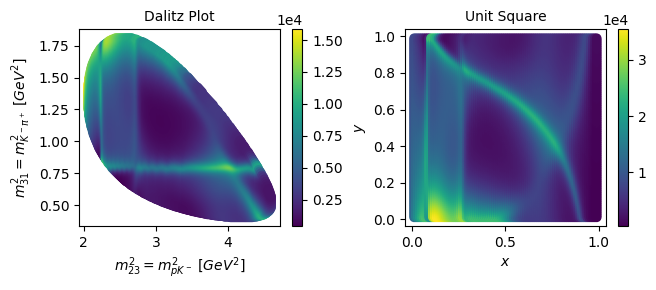

In [3]:
s23vs = jnp.linspace(target.m2 + target.m3, target.m0 - target.m1, 200)[1:-1]**2
s31vs = jnp.linspace(target.m3 + target.m1, target.m0 - target.m2, 202)[1:-1]**2
grid = jnp.dstack(jnp.meshgrid(s23vs, s31vs))
grid = grid.reshape([-1, 2])
p_vals = target.get_decay_rate(grid)

x = jnp.linspace(0., 1., 100)[1:-1]
grid_unit = jnp.dstack(jnp.meshgrid(x, x))
grid_unit = grid_unit.reshape([-1, 2])
p_vals_square = target.prob_no_nan(grid_unit)

fig, axes = plt.subplots(1, 2, figsize=(6.75,3))
colorbar = axes[0].scatter(grid[:,1], grid[:,0], c=p_vals.T)
cbar = fig.colorbar(colorbar, ax=axes[0])
cbar.formatter.set_powerlimits((0, 0))
axes[0].set_xlabel(r"$m_{23}^2 = m_{pK^-}^2 ~ [GeV^2]$")
axes[0].set_ylabel(r"$m_{31}^2 = m_{K^-\pi^+}^2 ~ [GeV^2]$")
axes[0].set_title('Dalitz Plot', fontsize=10)

colorbar = axes[1].scatter(grid_unit[:,1], grid_unit[:,0], c=p_vals_square)
cbar = fig.colorbar(colorbar, ax=axes[1])
cbar.formatter.set_powerlimits((0, 0))
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$y$')
axes[1].set_title('Unit Square', fontsize=10)
plt.tight_layout();

As well as the RHMC functions:

In [4]:
from rhmcjax.rhmc.rhmc import rhmc

In [5]:
inv_mass_matrix = jnp.array([0.1]*dim)
num_integration_steps = 60
num_chains = 10
num_samples_per_chain = 50_000
step_size = 1e-3

logdensity_fn = target.log_prob
key = jax.random.PRNGKey(1)

In [6]:
def run_rhmc(key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)

    keys = jax.random.split(key, num_samples)
    final_state, (states, info) = jax.lax.scan(one_step, initial_state, keys)

    return states, info

In [7]:
key, subkey = jax.random.split(key)
initial_positions = jax.random.uniform(subkey, shape=[num_chains, dim])
rhmc_sampler = rhmc(logdensity_fn, step_size, inv_mass_matrix, num_integration_steps)

chains = []
for init_p in initial_positions:
    key, subkey = jax.random.split(key)
    initial_state = rhmc_sampler.init(init_p)
    state, info = run_rhmc(subkey, rhmc_sampler.step, initial_state, num_samples_per_chain)
    chains.append(state.position[info.is_accepted].squeeze())
mcmc_chains_refl = jnp.vstack(chains)
mcmc_chains_refl.shape

(499793, 2)

The acceptance rate of RHMC for $\Lambda_c^+ \rightarrow p K^- \pi^+$ is:

In [8]:
print(f'Acceptance rate of RHMC on Lc2pKpi: {len(mcmc_chains_refl)/num_samples_per_chain * 10}%')

Acceptance rate of RHMC on Lc2pKpi: 99.9586%


We can plot the 2d histograms of the obtained samples and compare them to the true distribution.

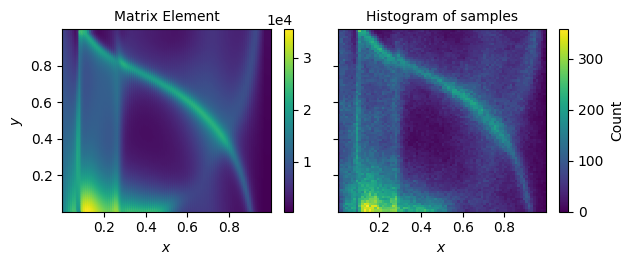

In [9]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6.5,2.75))
colorbar = axes[0].scatter(grid_unit[:,1], grid_unit[:,0], c=p_vals_square)
cbar = fig.colorbar(colorbar, ax=axes[0])
cbar.formatter.set_powerlimits((0, 0))
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$y$')
axes[0].set_title('Matrix Element', fontsize=10)

h, x, y, img = axes[1].hist2d(mcmc_chains_refl[:,1], mcmc_chains_refl[:,0], bins=80)
cbar = fig.colorbar(img, ax=axes[1])
cbar.set_label('Count')
axes[1].set_xlabel(r'$x$')
axes[1].set_title('Histogram of samples', fontsize=10)
plt.tight_layout();

We can also backtransform the samples to the Dalitz plot:

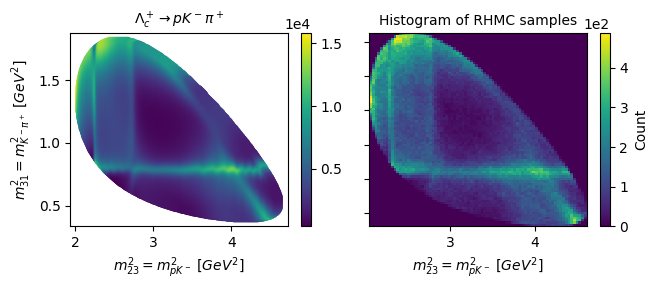

In [11]:
mcmc_chains_dp = target.transform_samples_to_physical_space(mcmc_chains_refl)

fig, axes = plt.subplots(1, 2, figsize=(6.75,3))
colorbar = axes[0].scatter(grid[:,1], grid[:,0], c=p_vals.T)
cbar = fig.colorbar(colorbar, ax=axes[0])
cbar.formatter.set_powerlimits((0, 0))
axes[0].set_xlabel(r"$m_{23}^2 = m_{pK^-}^2 ~ [GeV^2]$")
axes[0].set_ylabel(r"$m_{31}^2 = m_{K^-\pi^+}^2 ~ [GeV^2]$")
axes[0].set_title(r'$\Lambda_c^+ \rightarrow p K^- \pi^+$', fontsize=10)

h, x, y, img = axes[1].hist2d(mcmc_chains_dp[:,1], mcmc_chains_dp[:,0], bins=80)
cbar = fig.colorbar(img, ax=axes[1])
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label('Count')
axes[1].set_xlabel(r"$m_{23}^2 = m_{pK^-}^2 ~ [GeV^2]$")
axes[1].set_title('Histogram of RHMC samples', fontsize=10)
axes[1].yaxis.set_ticklabels([])
plt.tight_layout();
plt.savefig("../images/Lc2pKpi.png", dpi=200)